<a href="https://colab.research.google.com/github/Carhuacusma/CC61_PDI_Trabajo_Final/blob/main/CC61_PDI_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CC61: Procesamiento de Imágenes
#**Trabajo Final**

Alumnos:
* Galván Díaz, Joaquín Adrían : u201810A.
* Moreno Carhuacusma, Dante Brandon : u201818067

## Objetivos

## Desarrollo

###Importación de librerías

In [3]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from google.colab.patches import cv2_imshow

In [7]:
!pip install scikits.audiolab

In [9]:
from scikits.audiolab import play

ModuleNotFoundError: ignored

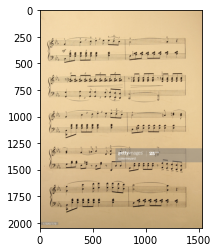

In [ ]:
imagen = io.imread("https://media.gettyimages.com/photos/antique-sheet-music-picture-id172207779?s=2048x2048") #..Considerar: io.imread lee en RGB
#.........................................................cv2 imshow es en BGR
plt.imshow(imagen)

In [ ]:
imagen = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)
im_canny = cv2.Canny(imagen,50,220)

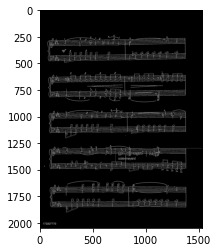

In [ ]:
plt.imshow(im_canny,cmap='gray')

In [ ]:
contornos,_ = cv2.findContours(im_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
print(contornos)

In [ ]:
def rectificar(imagen):
  if len(imagen.shape) != 2:
    imagen = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)
  im_canny = cv2.Canny(imagen,50,210)
  contornos, _ = cv2.findContours(im_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  return im_canny